# Recognition and classification of Flower images using VGG16. (Transfer learning approach)

In [1]:
from google.colab import drive

# This will prompt for authorization.
# mounting the drive to access the dataset
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
#importing libraries

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import skimage as io
from skimage.morphology import binary_closing, binary_dilation, binary_erosion, binary_opening, selem

from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import Callback
from keras.optimizers import SGD
from keras.utils import Sequence
from keras.preprocessing.image import ImageDataGenerator

from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50

from keras.models import Sequential
from keras.layers import Dense, MaxPool2D, Conv2D, Activation, Dropout, Flatten
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from keras.optimizers import Adam


import os
import glob
import gc

#flower directory from google drive
print(os.listdir('/content/gdrive/MyDrive/flowers'))



['.DS_Store', 'dandelion', 'daisy', 'tulip', 'sunflower', 'rose']


In [3]:
tulip = '/content/gdrive/MyDrive/flowers/tulip/*'
rose = '/content/gdrive/MyDrive/flowers/rose/*'
dandelion = '/content/gdrive/MyDrive/flowers/dandelion/*'
sunflower = '/content/gdrive/MyDrive/flowers/sunflower/*'
daisy = '/content/gdrive/MyDrive/flowers/daisy/*'

In [4]:
#defing X and Y
X = []
y = []

In [5]:
def make_data(path, flower_type):
    paths = glob.glob(os.path.join(path))
    delete_rows = []
    for i, p in enumerate(paths):
        img = plt.imread(p)
        h,w,_ = img.shape
        
        if h>150 and w>150 and _==3: #  img.shape > (150,150,3):
            ## Custom code written here to avoid extra time to run
            img = img[int(h/2)-75 : int(h/2)+75,
                      int(w/2)-75 : int(w/2)+75, :]
            img = (img - np.min(img))/(np.max(img) - np.min(img))
            ## custom code for avoiding the extra execution time ends heres

            X.append(img)
            y.append(flower_type)
        else:
            delete_rows.append(i)
            continue
#         X.append(img)
#         y.append(flower_type)
        
flowers = ['tulip', 'rose', 'sunflower', 'daisy', 'dandelion']

In [6]:
make_data(tulip, 'tulip')
make_data(rose, 'rose')
make_data(sunflower, 'sunflower')
make_data(daisy, 'daisy')
make_data(dandelion, 'dandelion')

In [7]:
print('total no. of flowers {}'.format(len(X)))

total no. of flowers 4160


In [8]:
X[12].shape

(150, 150, 3)

# Randomly plotting Flower

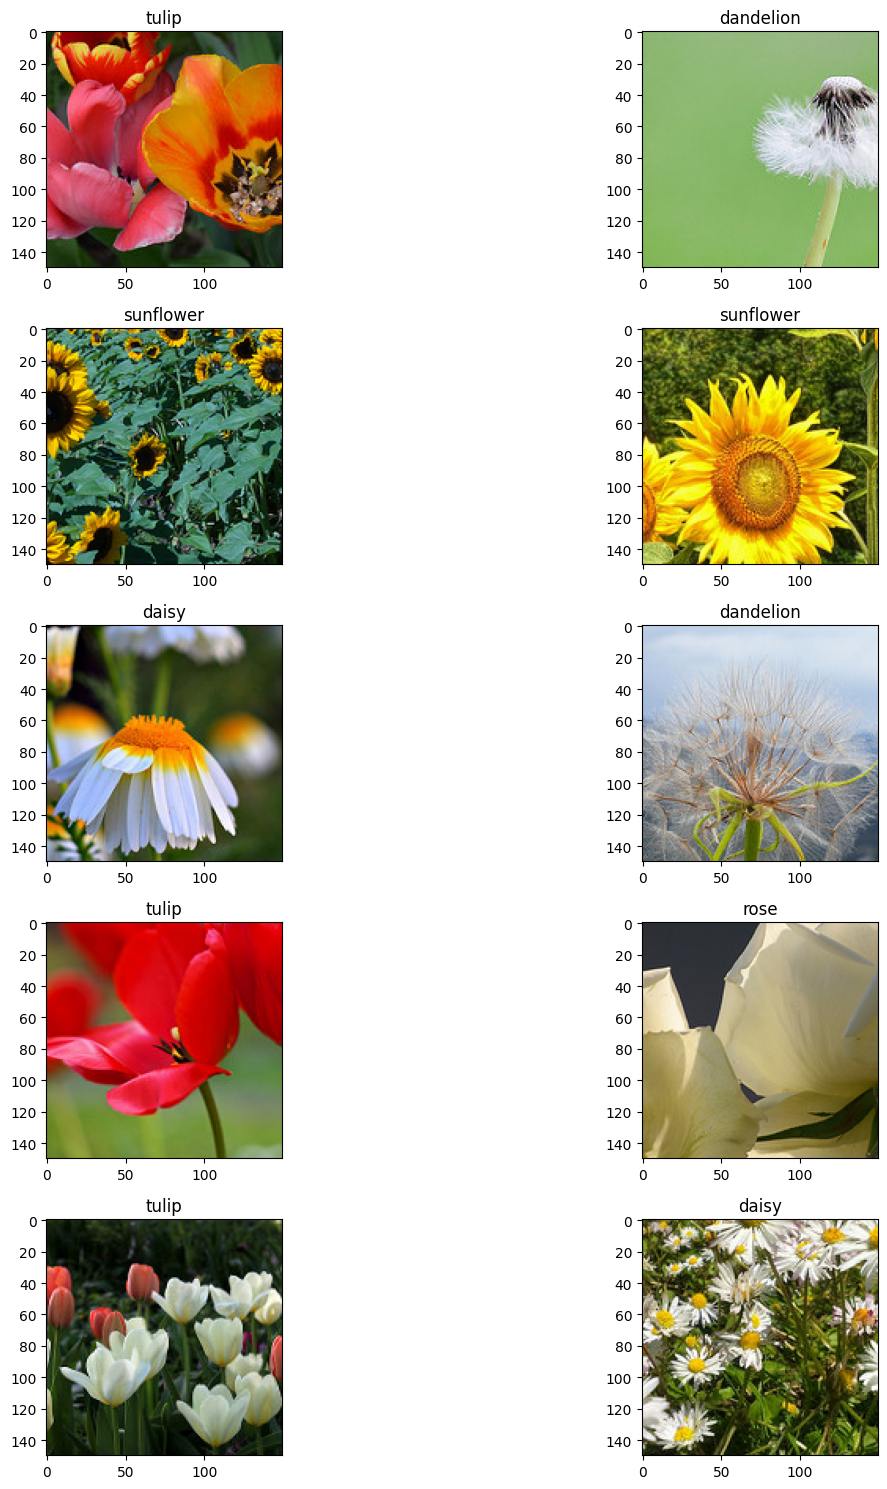

In [ ]:
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15, 15)
for i in range(5):
    for j in range(2):
        index = np.random.randint(len(y))
        ax[i, j].imshow(X[index])
        ax[i, j].set_title(y[index])
plt.tight_layout()
plt.show()

# Performing some basic image transformations

# A. Flower in RGB channels

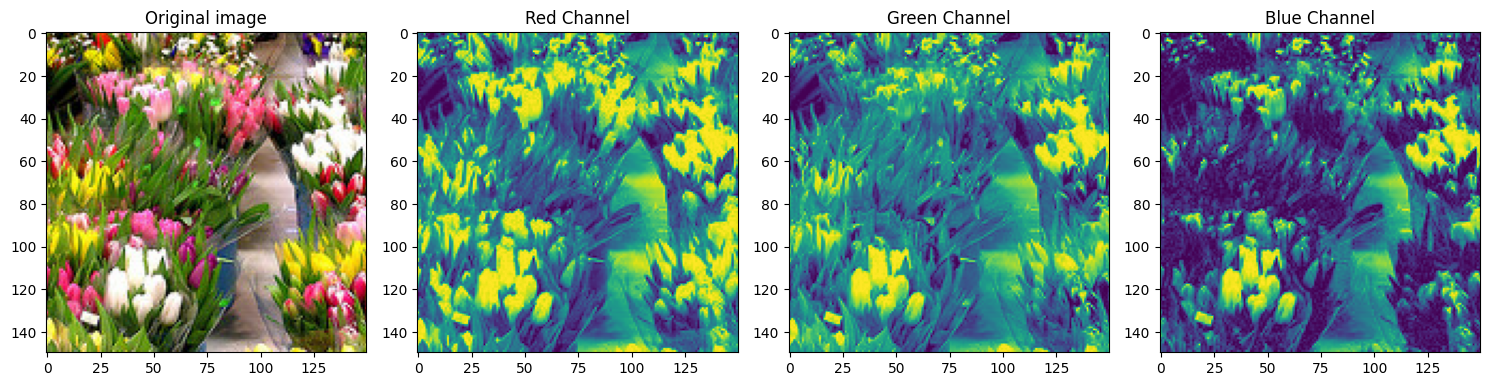

In [10]:
_, ax = plt.subplots(1,4)
_.set_size_inches(15,4)

ax[0].imshow(X[0])
ax[0].set_title('Original image')

ax[1].imshow(X[0][:,:, 0])
ax[1].set_title('Red Channel')

ax[2].imshow(X[0][:,:, 1])
ax[2].set_title('Green Channel')

ax[3].imshow(X[0][:,:, 2])
ax[3].set_title('Blue Channel')

plt.tight_layout()
plt.show()

# B. Morphological transformation

## Thresholding Considering threshold value to 150 
Pixels beyond 150 should me marked as 1 and others are marked as 0 

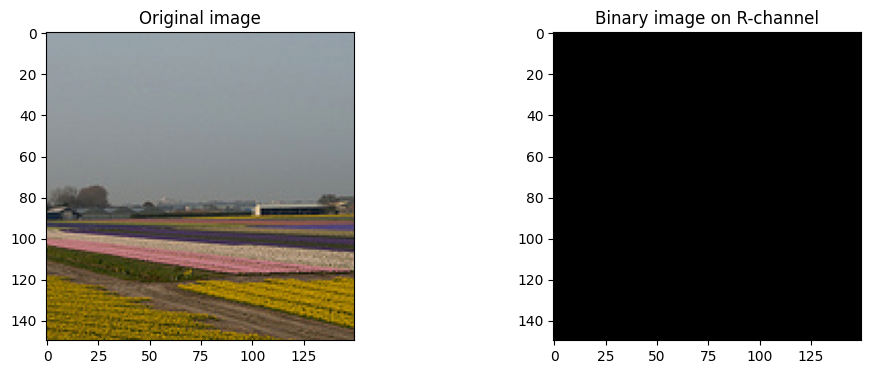

In [11]:
# Binary image R-channel
# 1929, 2263, 191, 1323, 3093, 342(final)
# index = np.random.randint(len(y))
index = 342

bin_img = X[index][:,:,0] > 150

_, ax = plt.subplots(1,2)
_.set_size_inches(12, 4)

ax[0].imshow(X[index], cmap='gray')
ax[0].set_title('Original image')

ax[1].imshow(bin_img, cmap='gray')
ax[1].set_title('Binary image on R-channel')
plt.show()


# Applying Morphological transformation

In [12]:
# Creating disk
disk = selem.disk(3)
# Erosion
erosion = binary_erosion(bin_img, disk)

# Dilation
dilation = binary_dilation(bin_img, disk)

# Opening
opening = binary_opening(bin_img, disk)

# Closing
closing = binary_closing(bin_img, disk)

Text(0.5, 1.0, 'Closing image')

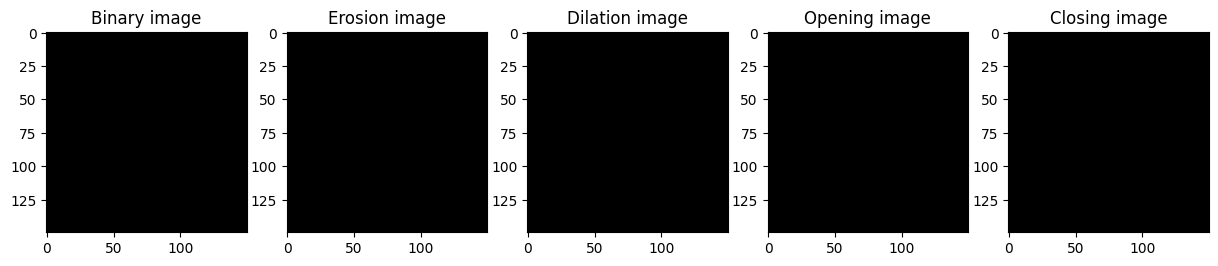

In [13]:
# Plotting binary and morphological images

_, ax = plt.subplots(1,5)

_.set_size_inches(15,4)

ax[0].imshow(bin_img, cmap='gray')
ax[0].set_title('Binary image')

ax[1].imshow(erosion, cmap='gray')
ax[1].set_title('Erosion image')

ax[2].imshow(dilation, cmap='gray')
ax[2].set_title('Dilation image')

ax[3].imshow(opening, cmap='gray')
ax[3].set_title('Opening image')

ax[4].imshow(closing, cmap='gray')
ax[4].set_title('Closing image')

# Image data Preprocessing 

In [14]:
X_final = np.empty((len(y), 150, 150, 3))
y_final = np.empty((len(y)))

## Preparing Train & test sets

In [15]:
# Making y_true to categorical with the help of LabelEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
flowers = ['tulip', 'rose', 'sunflower', 'daisy', 'dandelion']
flowers = flowers[::-1]
y_copy = y.copy()
print(y)
y = keras.utils.to_categorical(LabelEncoder().fit_transform(y))
print(y)

['tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 'tulip', 

Identifying the index of of the elements in the array (helpful in the end for outputing results)

In [16]:
#np.argmax(y[])
#np.unique(y)
# c =[]
# for i in range(0,len(y)): 
#   c.append(np.argmax(y[i]))
# print(np.unique(c))
print(np.argmax(y[-1]),y_copy[-1])
c= {}
for i in range(0,len(y)):
  c[np.argmax(y[i])]=y_copy[i]
print(c)

1 dandelion
{4: 'tulip', 2: 'rose', 3: 'sunflower', 0: 'daisy', 1: 'dandelion'}


In [17]:
def list_to_4d_metrix(l):
    x_final = np.empty((len(l), 150, 150, 3))
    
    for i, img in enumerate(l):
        x_final[i, ] = img
    
    return x_final

In [18]:
X = list_to_4d_metrix(X)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# VGG16 Model

In [20]:
base_model = VGG16(include_top=False, input_shape=(150,150,3), weights='imagenet', pooling='avg')

58889256/58889256 [==============================] - 3s 0us/step


In [21]:
model = Sequential()

In [22]:
model.add(base_model)
# model.add(Dense(512))
# model.add(Activation('relu'))

# model.add(Dropout(0.5))

# model.add(Dense(5))
# model.add(Activation('softmax'))

model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [23]:
base_model.trainable=False
print(model.summary())
# model.compile(optimizer=Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 14,847,301
Trainable params: 132,613
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [24]:
datagen = ImageDataGenerator(zca_whitening=False,
                             featurewise_center=False,
                             featurewise_std_normalization=False,
                             samplewise_center=False,
                             samplewise_std_normalization=False,
                             rotation_range=10,
                             horizontal_flip=True,
                             vertical_flip=False,
                             width_shift_range=0.1,
                             height_shift_range=0.1)

In [25]:
data=datagen.flow(X_train, y_train, batch_size=32)

In [26]:
def fit(model):
    model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='SGD')
    result = model.fit_generator(data,
                             epochs=32,
                             verbose=1,
                             steps_per_epoch=32,
                             validation_data=(X_test, y_test))
    return result

In [27]:
model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='SGD')
result = model.fit_generator(data,
                         epochs=32,
                         verbose=1,
                         steps_per_epoch=32,
                         validation_data=(X_test, y_test))

Epoch 1/32
32/32 [==============================] - 16s 199ms/step - loss: 1.5807 - accuracy: 0.2939 - val_loss: 1.4802 - val_accuracy: 0.4271
Epoch 2/32
32/32 [==============================] - 5s 169ms/step - loss: 1.4568 - accuracy: 0.4121 - val_loss: 1.4044 - val_accuracy: 0.4415
Epoch 3/32
32/32 [==============================] - 6s 172ms/step - loss: 1.3961 - accuracy: 0.4609 - val_loss: 1.3182 - val_accuracy: 0.5673
Epoch 4/32
32/32 [==============================] - 5s 170ms/step - loss: 1.3085 - accuracy: 0.5430 - val_loss: 1.2518 - val_accuracy: 0.5921
Epoch 5/32
32/32 [==============================] - 6s 176ms/step - loss: 1.2730 - accuracy: 0.5518 - val_loss: 1.2048 - val_accuracy: 0.6002
Epoch 6/32
32/32 [==============================] - 5s 170ms/step - loss: 1.2315 - accuracy: 0.5654 - val_loss: 1.1869 - val_accuracy: 0.5713
Epoch 7/32
32/32 [==============================] - 6s 176ms/step - loss: 1.1851 - accuracy: 0.5850 - val_loss: 1.1249 - val_accuracy: 0.6346
Epoch

In [28]:
def accuracy_loss_plot(result):
    _, ax = plt.subplots(1,2)
    _.set_figwidth(15)
    _.set_figheight(5)
    

    ax[0].plot(result.history['loss'], label='Training Loss')
    ax[0].plot(result.history['val_loss'], label='Testing Loss')
    ax[0].set_title('Loss')
    ax[0].legend()

    ax[1].plot(result.history['accuracy'], label='Training Accuracy')
    ax[1].plot(result.history['val_accuracy'], label='Testing Accuracy')
    ax[1].legend()
    ax[1].set_title('Accuracy')
    plt.tight_layout()
    plt.show()

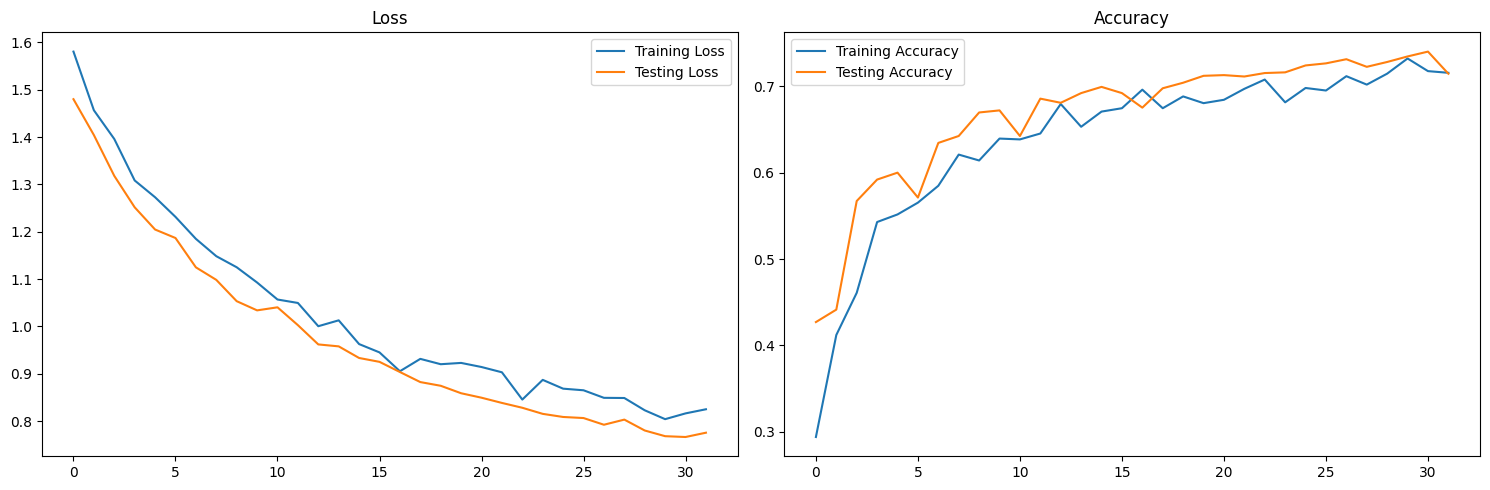

In [29]:
accuracy_loss_plot(result)

In [30]:
print(base_model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

# Freezing 0-17 layers for Transfer Learning

In [31]:
for i in range(len(base_model.layers[:18])):
    base_model.layers[i].trainable=False

for i in range(len(base_model.layers[18:])):
    base_model.layers[i].trainable=True

# Now training the model again with frozen untrainable layers 

In [32]:
model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='SGD')
result = model.fit_generator(data,
                         epochs=32,
                         verbose=1,
                         steps_per_epoch=32,
                         validation_data=(X_test, y_test))

Epoch 1/32
32/32 [==============================] - 7s 197ms/step - loss: 0.7979 - accuracy: 0.7109 - val_loss: 0.7594 - val_accuracy: 0.7396
Epoch 2/32
32/32 [==============================] - 6s 172ms/step - loss: 0.8238 - accuracy: 0.7061 - val_loss: 0.7484 - val_accuracy: 0.7396
Epoch 3/32
32/32 [==============================] - 5s 171ms/step - loss: 0.7875 - accuracy: 0.7266 - val_loss: 0.7506 - val_accuracy: 0.7380
Epoch 4/32
32/32 [==============================] - 6s 173ms/step - loss: 0.7987 - accuracy: 0.7197 - val_loss: 0.7456 - val_accuracy: 0.7412
Epoch 5/32
32/32 [==============================] - 5s 165ms/step - loss: 0.7813 - accuracy: 0.7305 - val_loss: 0.7298 - val_accuracy: 0.7460
Epoch 6/32
32/32 [==============================] - 6s 174ms/step - loss: 0.8046 - accuracy: 0.7178 - val_loss: 0.7419 - val_accuracy: 0.7332
Epoch 7/32
32/32 [==============================] - 5s 168ms/step - loss: 0.7772 - accuracy: 0.7334 - val_loss: 0.7241 - val_accuracy: 0.7468
Epoch 

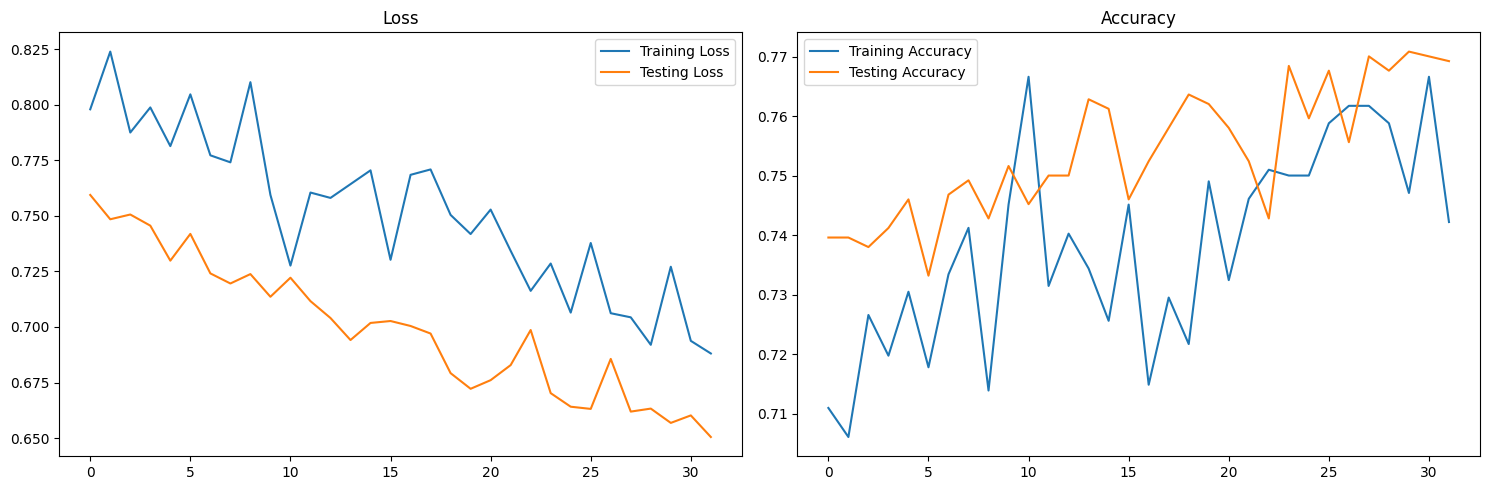

In [33]:
accuracy_loss_plot(result)

# Making last 5 layers of VGG16 trainable

In [34]:
for i in range(len(base_model.layers)):
    if i >= (len(base_model.layers)-5):
        base_model.layers[i].trainable = True
    else:
        base_model.layers[i].trainable = False

In [35]:
# Training the model
# result = fit(model)
model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='SGD')
result = model.fit_generator(data,
                         epochs=32,
                         verbose=1,
                         steps_per_epoch=32,
                         validation_data=(X_test, y_test))

Epoch 1/32
32/32 [==============================] - 7s 195ms/step - loss: 0.6652 - accuracy: 0.7588 - val_loss: 0.6426 - val_accuracy: 0.7772
Epoch 2/32
32/32 [==============================] - 6s 173ms/step - loss: 0.6862 - accuracy: 0.7578 - val_loss: 0.6519 - val_accuracy: 0.7636
Epoch 3/32
32/32 [==============================] - 5s 168ms/step - loss: 0.6660 - accuracy: 0.7930 - val_loss: 0.6464 - val_accuracy: 0.7716
Epoch 4/32
32/32 [==============================] - 5s 168ms/step - loss: 0.6719 - accuracy: 0.7617 - val_loss: 0.6491 - val_accuracy: 0.7756
Epoch 5/32
32/32 [==============================] - 6s 172ms/step - loss: 0.6682 - accuracy: 0.7588 - val_loss: 0.6487 - val_accuracy: 0.7676
Epoch 6/32
32/32 [==============================] - 5s 168ms/step - loss: 0.6803 - accuracy: 0.7598 - val_loss: 0.6320 - val_accuracy: 0.7780
Epoch 7/32
32/32 [==============================] - 6s 177ms/step - loss: 0.6538 - accuracy: 0.7695 - val_loss: 0.6548 - val_accuracy: 0.7684
Epoch 

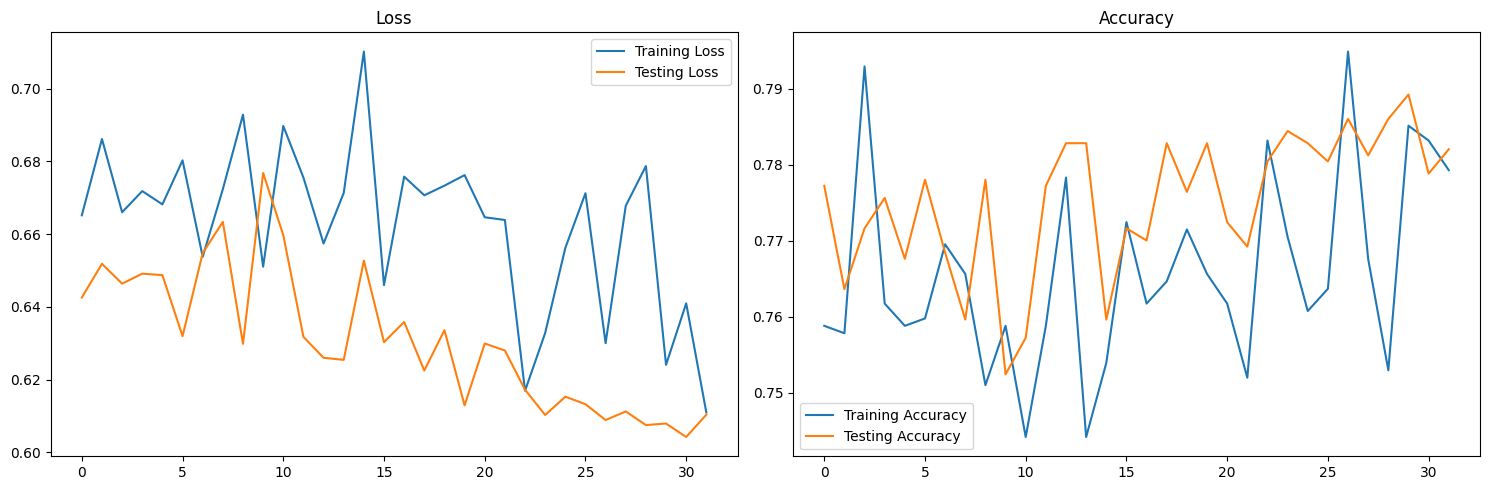

In [36]:
accuracy_loss_plot(result)

# Training full network with no layers frozen

In [37]:
base_model.trainable=True

In [38]:
# Training the model
model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='SGD')
result = model.fit_generator(data,
                         epochs=32,
                         verbose=1,
                         steps_per_epoch=32,
                         validation_data=(X_test, y_test))

Epoch 1/32
32/32 [==============================] - 11s 200ms/step - loss: 1.9789 - accuracy: 0.2471 - val_loss: 1.5812 - val_accuracy: 0.2644
Epoch 2/32
32/32 [==============================] - 6s 171ms/step - loss: 1.5834 - accuracy: 0.2568 - val_loss: 1.5652 - val_accuracy: 0.2660
Epoch 3/32
32/32 [==============================] - 6s 175ms/step - loss: 1.5914 - accuracy: 0.2822 - val_loss: 1.5652 - val_accuracy: 0.3285
Epoch 4/32
32/32 [==============================] - 5s 169ms/step - loss: 1.5737 - accuracy: 0.2793 - val_loss: 1.5284 - val_accuracy: 0.2845
Epoch 5/32
32/32 [==============================] - 6s 181ms/step - loss: 1.5731 - accuracy: 0.2822 - val_loss: 1.5946 - val_accuracy: 0.2676
Epoch 6/32
32/32 [==============================] - 5s 170ms/step - loss: 1.5687 - accuracy: 0.3232 - val_loss: 1.4931 - val_accuracy: 0.3646
Epoch 7/32
32/32 [==============================] - 6s 179ms/step - loss: 1.5343 - accuracy: 0.3135 - val_loss: 1.4664 - val_accuracy: 0.4054
Epoch

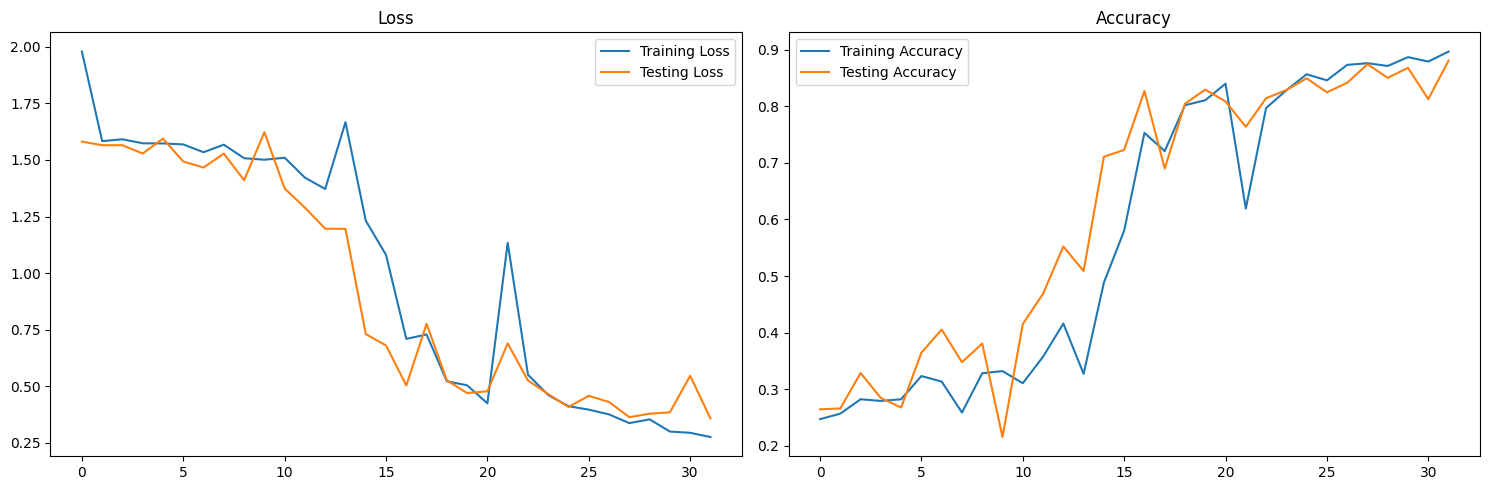

In [39]:
accuracy_loss_plot(result)

1/1 [==============================] - 0s 27ms/step


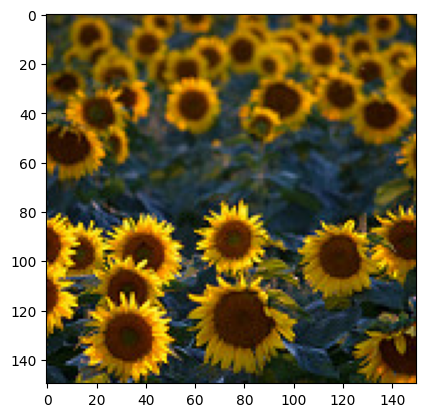


The given image is : sunflower


In [ ]:
import skimage.transform
path = "/content/gdrive/MyDrive/flowers/sunflower/20905163782_312e2c3bda_n.jpg"
img = plt.imread(path)
h,w,_ = img.shape
if h>150 and w > 150 and _==3: 
  #make sure the image size is more than 150 by 150
  img = img[int(h/2)-75 : int(h/2)+75, int(w/2)-75 : int(w/2)+75, :]
  img = (img - np.min(img))/(np.max(img) - np.min(img))
else:
  img = skimage.transform.resize(img, (150,150), anti_aliasing=True)
img = np.reshape(img, [1,150,150,3])
pred = model.predict(img)
#print(pred)
#print(c[np.argmax(pred)]) plt.title(c[np.argmax(pred)])
plt.figure()
plt.imshow(np.reshape(img, [150,150,3]))
plt.show()
print("\nThe given image is :",c[np.argmax(pred)])

1/1 [==============================] - 0s 21ms/step


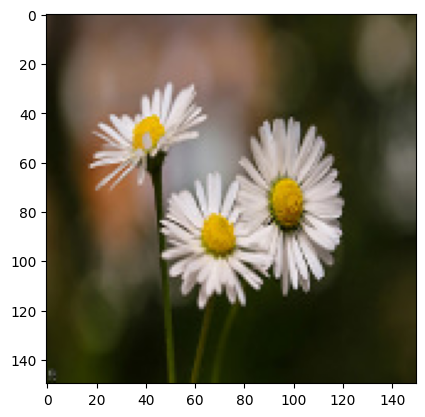


The given image is : daisy


In [42]:
path = "/content/gdrive/MyDrive/flowers/daisy/34652819496_0b6f758986_n.jpg"
img = plt.imread(path)
h,w,_ = img.shape
if h>150 and w > 150 and _==3: 
  #make sure the image size is more than 150 by 150
  img = img[int(h/2)-75 : int(h/2)+75, int(w/2)-75 : int(w/2)+75, :]
  img = (img - np.min(img))/(np.max(img) - np.min(img))
else:
  img = skimage.transform.resize(img, (150,150), anti_aliasing=True)
img = np.reshape(img, [1,150,150,3])
pred = model.predict(img)
#print(pred)
#print(c[np.argmax(pred)]) plt.title(c[np.argmax(pred)])
plt.figure()
plt.imshow(np.reshape(img, [150,150,3]))
plt.show()
print("\nThe given image is :",c[np.argmax(pred)])